In [282]:
bp = "PRJNA820450"
fastq_folder = f"/home/laura/projects/virus-watch-data/{bp}"
u_tax_tsv = "/home/laura/projects/virus-watch-data/virus_ref/u_tax_noduplicates.tsv"

In [283]:
import numpy as np
from scipy import stats
import anndata
import pandas as pd
import scanpy as sc
import json
import os
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
%config InlineBackend.figure_format='retina'

# Path to Krona tool
ktImportText = "/home/laura/bin/ktImportText"

def nd(arr):
    """
    Function to transform numpy matrix to nd array.
    """
    return np.asarray(arr).reshape(-1)

___
# Load data
Get SRRs:

In [284]:
srrs = []
for filename in glob.glob(f"{fastq_folder}/raw/*.fastq.gz"):
    srrs.append(filename.split("/")[-1].split("_")[0])
    
srrs = list(set(srrs))

srrs.sort()
print(len(srrs))
srrs[:10]

8


['SRR18496012',
 'SRR18496013',
 'SRR18496014',
 'SRR18496015',
 'SRR18496016',
 'SRR18496017',
 'SRR18496018',
 'SRR18496019']

### Load data aligned to PalmDB and add primer type and well from onlist based on the last 8 bases of barcode:

In [285]:
# Load barcode to well mapping
bc2well = pd.read_csv("splitseq_bc2well.csv")
bc2well

,bci,sequence,uid,well,type
0,1,CATTCCTA,pbs_1239,A1,T
1,2,CTTCATCA,pbs_1205,A2,T
2,3,CCTATATC,pbs_1247,A3,T
3,4,ACATTTAC,pbs_1211,A4,T
4,5,ACTTAGCT,pbs_1218,A5,T
...,...,...,...,...,...
187,188,GTGTGTGT,pbs_1355,H8,R
188,189,TATGCTTC,pbs_1361,H9,R
189,190,ATGGTGTT,pbs_1318,H10,R
190,191,GAATAATG,pbs_1164,H11,R


In [286]:
palmdb_adatas = []
for srr in srrs:
    # Load data   
    adata = anndata.read(f"{fastq_folder}/virus/{srr}/counts_unfiltered/adata.h5ad")

    # Add sample name
    adata.obs["srr"] = srr
    
    # Create new column containing identifying barcode
    adata.obs["iden_bc"] = adata.obs.index.str[-8:]

    # Create copy of barcode column
    adata.obs["barcode"] = adata.obs.index
    
    # Merge well and primer information
    adata.obs = adata.obs.merge(bc2well, left_on="iden_bc", right_on="sequence", how="left").set_index("barcode", drop=False)

    # Append to adata list
    palmdb_adatas.append(adata)

In [287]:
## Concatenate datasets
palmdb_adata = palmdb_adatas[0]
for adata_obj in palmdb_adatas[1:]:
    palmdb_adata = palmdb_adata.concatenate(adata_obj, 
                             join='outer', 
                             batch_key='sample_index',
                             batch_categories=None, 
                             uns_merge=None, 
                             fill_value=np.nan)
    
palmdb_adata

/home/laura/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


AnnData object with n_obs × n_vars = 64436 × 296561
    obs: 'srr', 'iden_bc', 'barcode', 'bci', 'sequence', 'uid', 'well', 'type', 'sample_index'

In [288]:
# Drop unnecessary/duplicated columns
palmdb_adata.obs = palmdb_adata.obs.drop(["sequence", "sample_index"], axis=1)
palmdb_adata.obs

,srr,iden_bc,barcode,bci,uid,well,type
barcode,,,,,,,
AAACATCGAACAACCAGAGCACAA-0-0-0-0-0-0-0,SRR18496012,GAGCACAA,AAACATCGAACAACCAGAGCACAA,77,pbs_1142,G5,T
AAACATCGAACCGAGAAATTTCTC-0-0-0-0-0-0-0,SRR18496012,AATTTCTC,AAACATCGAACCGAGAAATTTCTC,28,pbs_1115,C4,T
AAACATCGAACCGAGACCGTTCTA-0-0-0-0-0-0-0,SRR18496012,CCGTTCTA,AAACATCGAACCGAGACCGTTCTA,17,pbs_1111,B5,T
AAACATCGAACCGAGAGTGGGTTC-0-0-0-0-0-0-0,SRR18496012,GTGGGTTC,AAACATCGAACCGAGAGTGGGTTC,147,pbs_1185,E3,R
AAACATCGAACCGAGATTATTCTG-0-0-0-0-0-0-0,SRR18496012,TTATTCTG,AAACATCGAACCGAGATTATTCTG,14,pbs_1118,B2,T
...,...,...,...,...,...,...,...
TTCACGCAGCCACATAGAGGTTGA-1,SRR18496019,GAGGTTGA,TTCACGCAGCCACATAGAGGTTGA,145,pbs_1171,E1,R
TTCACGCAGTACGCAAGGTTCTTC-1,SRR18496019,GGTTCTTC,TTCACGCAGTACGCAAGGTTCTTC,116,pbs_1181,B8,R
TTCACGCAGTACGCAATTATTCTG-1,SRR18496019,TTATTCTG,TTCACGCAGTACGCAATTATTCTG,14,pbs_1118,B2,T


Add metadata:

In [289]:
# Load first set of metadata provided by authors
meta1 = pd.read_csv("GSM5974202_sample_well_IDs.tsv", sep='\t')
meta1["well_ID_list"] = meta1["well_ID"]
meta1["well_ID"] = meta1["well_ID_list"].str.split("-")
meta1 = meta1.explode("well_ID")
meta1.head()

,sample,well_ID,well_ID_list
0,ctrl_01_E2,A1,A1-A2
0,ctrl_01_E2,A2,A1-A2
1,ctrl_02_E2,A3,A3-A4
1,ctrl_02_E2,A4,A3-A4
2,ctrl_03_E2,A5,A5-A6


In [290]:
# Copy current index
palmdb_adata.obs["barcode_idx"] = palmdb_adata.obs.index.values

In [291]:
palmdb_adata.obs = palmdb_adata.obs.merge(meta1, left_on="well", right_on="well_ID", how="left").drop("well_ID_list", axis=1)
palmdb_adata.obs

/home/laura/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


,srr,iden_bc,barcode,bci,uid,well,type,barcode_idx,sample,well_ID
0,SRR18496012,GAGCACAA,AAACATCGAACAACCAGAGCACAA,77,pbs_1142,G5,T,AAACATCGAACAACCAGAGCACAA-0-0-0-0-0-0-0,NaN,NaN
1,SRR18496012,AATTTCTC,AAACATCGAACCGAGAAATTTCTC,28,pbs_1115,C4,T,AAACATCGAACCGAGAAATTTCTC-0-0-0-0-0-0-0,inf_05_E4,C4
2,SRR18496012,CCGTTCTA,AAACATCGAACCGAGACCGTTCTA,17,pbs_1111,B5,T,AAACATCGAACCGAGACCGTTCTA-0-0-0-0-0-0-0,ctrl_09_E4,B5
3,SRR18496012,GTGGGTTC,AAACATCGAACCGAGAGTGGGTTC,147,pbs_1185,E3,R,AAACATCGAACCGAGAGTGGGTTC-0-0-0-0-0-0-0,NaN,NaN
4,SRR18496012,TTATTCTG,AAACATCGAACCGAGATTATTCTG,14,pbs_1118,B2,T,AAACATCGAACCGAGATTATTCTG-0-0-0-0-0-0-0,ctrl_07_E4,B2
...,...,...,...,...,...,...,...,...,...,...
64431,SRR18496019,GAGGTTGA,TTCACGCAGCCACATAGAGGTTGA,145,pbs_1171,E1,R,TTCACGCAGCCACATAGAGGTTGA-1,NaN,NaN
64432,SRR18496019,GGTTCTTC,TTCACGCAGTACGCAAGGTTCTTC,116,pbs_1181,B8,R,TTCACGCAGTACGCAAGGTTCTTC-1,inf_01_E2,B8
64433,SRR18496019,TTATTCTG,TTCACGCAGTACGCAATTATTCTG,14,pbs_1118,B2,T,TTCACGCAGTACGCAATTATTCTG-1,ctrl_07_E4,B2
64434,SRR18496019,GAGGTTGA,TTCACGCAGTGTTCTAGAGGTTGA,145,pbs_1171,E1,R,TTCACGCAGTGTTCTAGAGGTTGA-1,NaN,NaN


In [292]:
# Load second set of metadata provided by authors
meta2 = pd.read_csv("GSM5974202_README.txt", sep='\t')
meta2.head()

,Sample_name,title,source_name,organism,APOE_genotype,condition
0,ctrl_01_E2,Non-infected APOE2 mouse rep 01,Lung,Mus musculus,APOE2,non-infected
1,ctrl_02_E2,Non-infected APOE2 mouse rep 02,Lung,Mus musculus,APOE2,non-infected
2,ctrl_03_E2,Non-infected APOE2 mouse rep 03,Lung,Mus musculus,APOE2,non-infected
3,ctrl_04_E3,Non-infected APOE3 mouse rep 01,Lung,Mus musculus,APOE3,non-infected
4,ctrl_05_E3,Non-infected APOE3 mouse rep 02,Lung,Mus musculus,APOE3,non-infected


In [293]:
palmdb_adata.obs = palmdb_adata.obs.merge(meta2, left_on="sample", right_on="Sample_name", how="left").set_index("barcode_idx", drop=True)
palmdb_adata.obs

,srr,iden_bc,barcode,bci,uid,well,type,sample,well_ID,Sample_name,title,source_name,organism,APOE_genotype,condition
barcode_idx,,,,,,,,,,,,,,,
AAACATCGAACAACCAGAGCACAA-0-0-0-0-0-0-0,SRR18496012,GAGCACAA,AAACATCGAACAACCAGAGCACAA,77,pbs_1142,G5,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACATCGAACCGAGAAATTTCTC-0-0-0-0-0-0-0,SRR18496012,AATTTCTC,AAACATCGAACCGAGAAATTTCTC,28,pbs_1115,C4,T,inf_05_E4,C4,inf_05_E4,Infected APOE4 mouse rep 01,Lung,Mus musculus,APOE4,infected
AAACATCGAACCGAGACCGTTCTA-0-0-0-0-0-0-0,SRR18496012,CCGTTCTA,AAACATCGAACCGAGACCGTTCTA,17,pbs_1111,B5,T,ctrl_09_E4,B5,ctrl_09_E4,Non-infected APOE4 mouse rep 03,Lung,Mus musculus,APOE4,non-infected
AAACATCGAACCGAGAGTGGGTTC-0-0-0-0-0-0-0,SRR18496012,GTGGGTTC,AAACATCGAACCGAGAGTGGGTTC,147,pbs_1185,E3,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACATCGAACCGAGATTATTCTG-0-0-0-0-0-0-0,SRR18496012,TTATTCTG,AAACATCGAACCGAGATTATTCTG,14,pbs_1118,B2,T,ctrl_07_E4,B2,ctrl_07_E4,Non-infected APOE4 mouse rep 01,Lung,Mus musculus,APOE4,non-infected
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTCACGCAGCCACATAGAGGTTGA-1,SRR18496019,GAGGTTGA,TTCACGCAGCCACATAGAGGTTGA,145,pbs_1171,E1,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TTCACGCAGTACGCAAGGTTCTTC-1,SRR18496019,GGTTCTTC,TTCACGCAGTACGCAAGGTTCTTC,116,pbs_1181,B8,R,inf_01_E2,B8,inf_01_E2,Infected APOE2 mouse rep 01,Lung,Mus musculus,APOE2,infected
TTCACGCAGTACGCAATTATTCTG-1,SRR18496019,TTATTCTG,TTCACGCAGTACGCAATTATTCTG,14,pbs_1118,B2,T,ctrl_07_E4,B2,ctrl_07_E4,Non-infected APOE4 mouse rep 01,Lung,Mus musculus,APOE4,non-infected


In [294]:
# Note: More than half of the well should have been empty since they are not included in look-up included by authors
palmdb_adata.obs.dropna()

,srr,iden_bc,barcode,bci,uid,well,type,sample,well_ID,Sample_name,title,source_name,organism,APOE_genotype,condition
barcode_idx,,,,,,,,,,,,,,,
AAACATCGAACCGAGAAATTTCTC-0-0-0-0-0-0-0,SRR18496012,AATTTCTC,AAACATCGAACCGAGAAATTTCTC,28,pbs_1115,C4,T,inf_05_E4,C4,inf_05_E4,Infected APOE4 mouse rep 01,Lung,Mus musculus,APOE4,infected
AAACATCGAACCGAGACCGTTCTA-0-0-0-0-0-0-0,SRR18496012,CCGTTCTA,AAACATCGAACCGAGACCGTTCTA,17,pbs_1111,B5,T,ctrl_09_E4,B5,ctrl_09_E4,Non-infected APOE4 mouse rep 03,Lung,Mus musculus,APOE4,non-infected
AAACATCGAACCGAGATTATTCTG-0-0-0-0-0-0-0,SRR18496012,TTATTCTG,AAACATCGAACCGAGATTATTCTG,14,pbs_1118,B2,T,ctrl_07_E4,B2,ctrl_07_E4,Non-infected APOE4 mouse rep 01,Lung,Mus musculus,APOE4,non-infected
AAACATCGAACTCACCTTCGCTAC-0-0-0-0-0-0-0,SRR18496012,TTCGCTAC,AAACATCGAACTCACCTTCGCTAC,47,pbs_1132,D11,T,inf_20_E4,D11,inf_20_E4,Infected APOE4 mouse rep 08,Lung,Mus musculus,APOE4,infected
AAACATCGAAGGTACATTATTCTG-0-0-0-0-0-0-0,SRR18496012,TTATTCTG,AAACATCGAAGGTACATTATTCTG,14,pbs_1118,B2,T,ctrl_07_E4,B2,ctrl_07_E4,Non-infected APOE4 mouse rep 01,Lung,Mus musculus,APOE4,non-infected
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTCACGCACGACTGGATTCGCTAC-1,SRR18496019,TTCGCTAC,TTCACGCACGACTGGATTCGCTAC,47,pbs_1132,D11,T,inf_20_E4,D11,inf_20_E4,Infected APOE4 mouse rep 08,Lung,Mus musculus,APOE4,infected
TTCACGCACTAAGGTCGTCATATG-1,SRR18496019,GTCATATG,TTCACGCACTAAGGTCGTCATATG,126,pbs_1160,C6,R,inf_06_E4,C6,inf_06_E4,Infected APOE4 mouse rep 02,Lung,Mus musculus,APOE4,infected
TTCACGCAGAGCTGAAGCTGCATG-1,SRR18496019,GCTGCATG,TTCACGCAGAGCTGAAGCTGCATG,113,pbs_1159,B5,R,ctrl_09_E4,B5,ctrl_09_E4,Non-infected APOE4 mouse rep 03,Lung,Mus musculus,APOE4,non-infected


### Load data aligned to host genome:

In [295]:
host_adata = anndata.read(f"{fastq_folder}/host/host_filtered_norm.h5ad")
host_adata

AnnData object with n_obs × n_vars = 11718 × 57010
    obs: 'srr', 'iden_bc', 'barcode', 'bci', 'uid', 'well', 'type', 'percent_mito', 'n_counts', 'n_genes', 'sample', 'well_ID', 'Sample_name', 'title', 'source_name', 'organism', 'APOE_genotype', 'condition', 'genotype_condition', 'leiden'
    var: 'ensembl_id', 'gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dendrogram_leiden', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

### Load virus ID to taxonomy mapping:

In [296]:
id2tax_df = pd.read_csv(u_tax_tsv, sep='\t')
id2tax_df.head()

,Label,phylum,class,order,family,genus,species
0,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...
1,u10,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Ebolavirus,Zaire ebolavirus
2,u100,Kitrinoviricota,Flasuviricetes,Amarillovirales,Flaviviridae,Flavivirus,West Nile virus
3,u1000,Negarnaviricota,Monjiviricetes,Mononegavirales,Paramyxoviridae,Henipavirus,Hendra henipavirus
4,u10000,Pisuviricota,Pisoniviricetes,Picornavirales,Caliciviridae,Norovirus,Norwalk virus


In [297]:
target_ids = id2tax_df[id2tax_df["species"].str.contains("Severe acute respiratory syndrome-related coronavirus")]["Label"].values

Note: Aligning without barcode correction keeps about 3x more SARS-COV2 reads

In [298]:
palmdb_adata[:, palmdb_adata.var.index.isin(target_ids)].X.sum()

9201.0

### Number of SARS-COV2 counts per condition:

In [299]:
palmdb_adata[(palmdb_adata.obs["condition"]=="infected") & (palmdb_adata.obs["type"]=="T"), palmdb_adata.var.index.isin(target_ids)].X.sum()

179.0

In [300]:
palmdb_adata[(palmdb_adata.obs["condition"]=="infected") & (palmdb_adata.obs["type"]=="R"), palmdb_adata.var.index.isin(target_ids)].X.sum()

2030.0

In [301]:
palmdb_adata[(palmdb_adata.obs["condition"]=="non-infected") & (palmdb_adata.obs["type"]=="T"), palmdb_adata.var.index.isin(target_ids)].X.sum()

264.0

In [302]:
palmdb_adata[(palmdb_adata.obs["condition"]=="non-infected") & (palmdb_adata.obs["type"]=="R"), palmdb_adata.var.index.isin(target_ids)].X.sum()

329.0

### Total number of virus counts per condition:

In [303]:
palmdb_adata[(palmdb_adata.obs["condition"]=="infected") & (palmdb_adata.obs["type"]=="R"), :].X.sum()

10995.0

In [304]:
palmdb_adata[(palmdb_adata.obs["condition"]=="non-infected") & (palmdb_adata.obs["type"]=="R"), :].X.sum()

4477.0

___
### Mark barcodes in virus matrix that survived host cell QC

In [305]:
host_adata.obs["host_QC"] = "good"
host_adata.obs

,srr,iden_bc,barcode,bci,uid,well,type,percent_mito,n_counts,n_genes,...,well_ID,Sample_name,title,source_name,organism,APOE_genotype,condition,genotype_condition,leiden,host_QC
barcode_idx,,,,,,,,,,,,,,,,,,,,,
AAACATCGAACCGAGACCGTTCTA-0-0-0-0-0-0-0,SRR18496012,CCGTTCTA,AAACATCGAACCGAGACCGTTCTA,17,pbs_1111,B5,T,0.0039525693,253.0,140,...,B5,ctrl_09_E4,Non-infected APOE4 mouse rep 03,Lung,Mus musculus,APOE4,non-infected,APOE4_non-infected,32,good
AAACATCGAACCGAGAGCTTATAG-0-0-0-0-0-0-0,SRR18496012,GCTTATAG,AAACATCGAACCGAGAGCTTATAG,100,pbs_1166,A4,R,0.015384615,715.0,419,...,A4,ctrl_02_E2,Non-infected APOE2 mouse rep 02,Lung,Mus musculus,APOE2,non-infected,APOE2_non-infected,6,good
AAACATCGAACCGAGATTATTCTG-0-0-0-0-0-0-0,SRR18496012,TTATTCTG,AAACATCGAACCGAGATTATTCTG,14,pbs_1118,B2,T,0.017723246,1467.0,709,...,B2,ctrl_07_E4,Non-infected APOE4 mouse rep 01,Lung,Mus musculus,APOE4,non-infected,APOE4_non-infected,10,good
AAACATCGAAGGTACAGCTTATAG-0-0-0-0-0-0-0,SRR18496012,GCTTATAG,AAACATCGAAGGTACAGCTTATAG,100,pbs_1166,A4,R,0.0,247.0,179,...,A4,ctrl_02_E2,Non-infected APOE2 mouse rep 02,Lung,Mus musculus,APOE2,non-infected,APOE2_non-infected,13,good
AAACATCGAAGGTACATTATTCTG-0-0-0-0-0-0-0,SRR18496012,TTATTCTG,AAACATCGAAGGTACATTATTCTG,14,pbs_1118,B2,T,0.0,557.0,323,...,B2,ctrl_07_E4,Non-infected APOE4 mouse rep 01,Lung,Mus musculus,APOE4,non-infected,APOE4_non-infected,25,good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTCACGCACAATGGAAGCTTATAG-1,SRR18496019,GCTTATAG,TTCACGCACAATGGAAGCTTATAG,100,pbs_1166,A4,R,0.017482517,286.0,171,...,A4,ctrl_02_E2,Non-infected APOE2 mouse rep 02,Lung,Mus musculus,APOE2,non-infected,APOE2_non-infected,13,good
TTCACGCACAATGGAATTATTCTG-1,SRR18496019,TTATTCTG,TTCACGCACAATGGAATTATTCTG,14,pbs_1118,B2,T,0.034749035,518.0,265,...,B2,ctrl_07_E4,Non-infected APOE4 mouse rep 01,Lung,Mus musculus,APOE4,non-infected,APOE4_non-infected,25,good
TTCACGCAGACTAGTACCATCTTG-1,SRR18496019,CCATCTTG,TTCACGCAGACTAGTACCATCTTG,129,pbs_1169,C9,R,0.0,769.0,299,...,C9,inf_08_E2,Infected APOE2 mouse rep 03,Lung,Mus musculus,APOE2,infected,APOE2_infected,6,good


In [306]:
palmdb_adata.obs["barcode_idx"] = palmdb_adata.obs.index.values
palmdb_adata.obs = palmdb_adata.obs.merge(host_adata.obs[["srr", "barcode", "host_QC", "leiden"]],  how='left', on=['srr', 'barcode'], suffixes=["", "_host"], validate="one_to_one").set_index("barcode_idx")

In [307]:
palmdb_adata.obs = palmdb_adata.obs.rename(columns={'leiden': 'host_leiden'})

In [308]:
palmdb_adata.obs[palmdb_adata.obs["host_QC"]=="good"].dropna()

,srr,iden_bc,barcode,bci,uid,well,type,sample,well_ID,Sample_name,title,source_name,organism,APOE_genotype,condition,host_QC,host_leiden
barcode_idx,,,,,,,,,,,,,,,,,
AAACATCGAACCGAGACCGTTCTA-0-0-0-0-0-0-0,SRR18496012,CCGTTCTA,AAACATCGAACCGAGACCGTTCTA,17,pbs_1111,B5,T,ctrl_09_E4,B5,ctrl_09_E4,Non-infected APOE4 mouse rep 03,Lung,Mus musculus,APOE4,non-infected,good,32
AAACATCGAACCGAGATTATTCTG-0-0-0-0-0-0-0,SRR18496012,TTATTCTG,AAACATCGAACCGAGATTATTCTG,14,pbs_1118,B2,T,ctrl_07_E4,B2,ctrl_07_E4,Non-infected APOE4 mouse rep 01,Lung,Mus musculus,APOE4,non-infected,good,10
AAACATCGAAGGTACATTATTCTG-0-0-0-0-0-0-0,SRR18496012,TTATTCTG,AAACATCGAAGGTACATTATTCTG,14,pbs_1118,B2,T,ctrl_07_E4,B2,ctrl_07_E4,Non-infected APOE4 mouse rep 01,Lung,Mus musculus,APOE4,non-infected,good,25
AAACATCGAGATGTACGCTTATAG-0-0-0-0-0-0-0,SRR18496012,GCTTATAG,AAACATCGAGATGTACGCTTATAG,100,pbs_1166,A4,R,ctrl_02_E2,A4,ctrl_02_E2,Non-infected APOE2 mouse rep 02,Lung,Mus musculus,APOE2,non-infected,good,21
AAACATCGAGATGTACTTATTCTG-0-0-0-0-0-0-0,SRR18496012,TTATTCTG,AAACATCGAGATGTACTTATTCTG,14,pbs_1118,B2,T,ctrl_07_E4,B2,ctrl_07_E4,Non-infected APOE4 mouse rep 01,Lung,Mus musculus,APOE4,non-infected,good,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGGTGGTAGAATCTGAGCAAATTC-1,SRR18496019,GCAAATTC,TGGTGGTAGAATCTGAGCAAATTC,144,pbs_1182,D12,R,inf_23_E3,D12,inf_23_E3,Infected APOE3 mouse rep 06,Lung,Mus musculus,APOE3,infected,good,2
TGGTGGTAGACTAGTAGTTACGTA-1,SRR18496019,GTTACGTA,TGGTGGTAGACTAGTAGTTACGTA,42,pbs_1144,D6,T,inf_15_E4,D6,inf_15_E4,Infected APOE4 mouse rep 05,Lung,Mus musculus,APOE4,infected,good,9
TTCACGCACAATGGAAGCTTATAG-1,SRR18496019,GCTTATAG,TTCACGCACAATGGAAGCTTATAG,100,pbs_1166,A4,R,ctrl_02_E2,A4,ctrl_02_E2,Non-infected APOE2 mouse rep 02,Lung,Mus musculus,APOE2,non-infected,good,13


SARS-CoV counts per condition using only cells that survived host QC:

In [309]:
palmdb_adata[(palmdb_adata.obs["condition"]=="infected") & (palmdb_adata.obs["type"]=="T") & (palmdb_adata.obs["host_QC"]=="good"), palmdb_adata.var.index.isin(target_ids)].X.sum()

54.0

In [310]:
palmdb_adata[(palmdb_adata.obs["condition"]=="infected") & (palmdb_adata.obs["type"]=="R") & (palmdb_adata.obs["host_QC"]=="good"), palmdb_adata.var.index.isin(target_ids)].X.sum()

495.0

In [311]:
palmdb_adata[(palmdb_adata.obs["condition"]=="non-infected") & (palmdb_adata.obs["type"]=="T") & (palmdb_adata.obs["host_QC"]=="good"), palmdb_adata.var.index.isin(target_ids)].X.sum()

103.0

In [312]:
palmdb_adata[(palmdb_adata.obs["condition"]=="non-infected") & (palmdb_adata.obs["type"]=="R") & (palmdb_adata.obs["host_QC"]=="good"), palmdb_adata.var.index.isin(target_ids)].X.sum()

77.0

___

In [313]:
# Drop all cells not in lookup
palmdb_adata_fil = palmdb_adata[palmdb_adata.obs["condition"].notnull(), :]

### Annotate highly variable

/home/laura/anaconda3/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


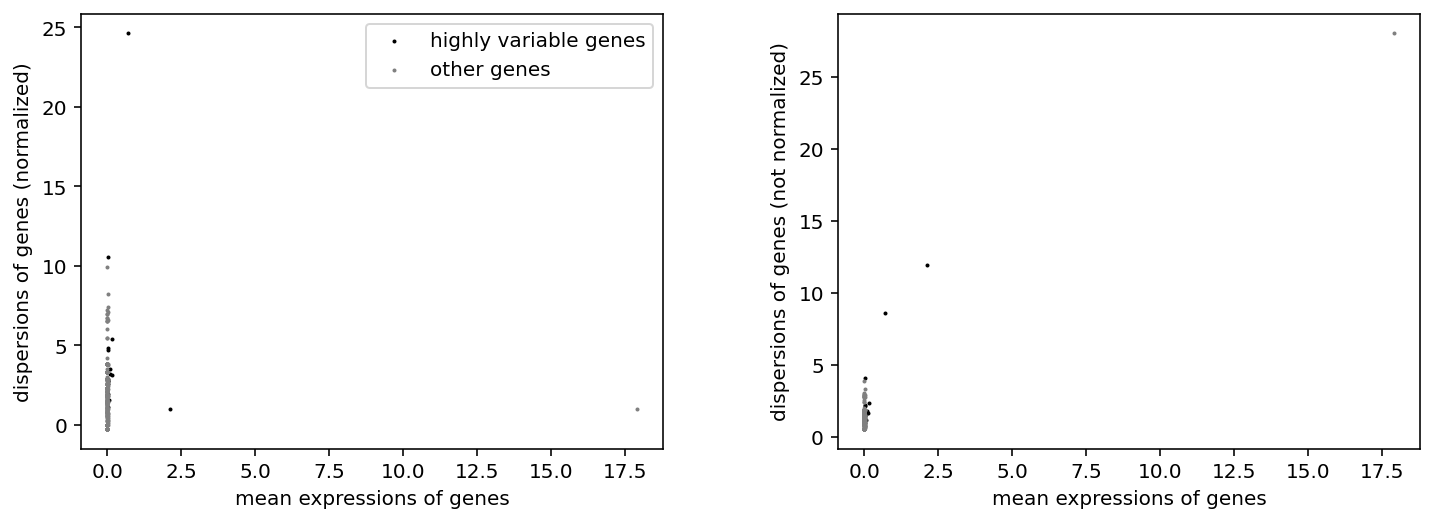

In [314]:
sc.pp.highly_variable_genes(palmdb_adata_fil)
sc.pl.highly_variable_genes(palmdb_adata_fil)

### PCA

In [315]:
# Perform PCA on just the highly variable genes
sc.tl.pca(palmdb_adata_fil, use_highly_variable=True)

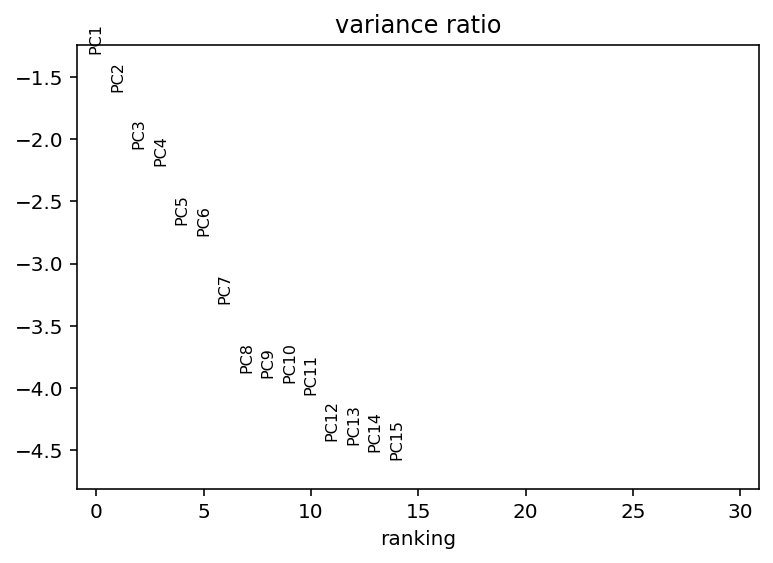

In [316]:
sc.pl.pca_variance_ratio(palmdb_adata_fil, log=True)

### Leiden clustering

In [317]:
# Define number of nearest neighbours based on the variance ratio plot above
n_neighbors = 10
n_pcs = 5

# Find nearest neighbors
sc.pp.neighbors(palmdb_adata_fil, n_neighbors=n_neighbors, n_pcs=n_pcs)

In [318]:
# Leiden clustering on the neighboorhood graph
sc.tl.leiden(palmdb_adata_fil, resolution=0.5)

In [319]:
def plot_fraction_per_sample(
    adata,
    groups="leiden",
    fractions="title",
    colors=None,
    frac_order=None, 
    group_order=None,
    normalize_to_total=False,
    title=None,
    xticklabel_rotation=0
):
    ## Save fractions to plot in dataframe
    # # Convert sample column to string (instead of categorical)
    # adata.obs[fractions] = adata.obs[fractions].astype(str)

    df_normalized = pd.DataFrame()

    if normalize_to_total:
        # Normalize each celltype count to total number of cells in that batch by dividing
        df_normalized = ((adata.obs.groupby(groups)[fractions].value_counts()/ adata.obs.groupby(fractions)["organism"].count())
            .unstack()
            .fillna(0)
        )
        # Convert columns to string
        df_normalized.columns = df_normalized.columns.astype(str)
        # Get total normalized count
        df_normalized["total_normalized_count"] = df_normalized.sum(axis=1).values

        # Compute fraction of normalized total count for each sample
        for sample in adata.obs[fractions].unique():
            df_normalized[f"{sample}_fraction"] = (df_normalized[sample] / df_normalized["total_normalized_count"]).values

    else:
        # Do not normalize to total count (use if we do not expect these to be equally distributed across the clusters)
        df_normalized = (adata.obs.groupby(groups)[fractions].value_counts().unstack().fillna(0))
        df_normalized["total_count"] = df_normalized.sum(axis=1).values

        for sample in df_normalized.columns[:-1]:
            df_normalized[f"{sample}_fraction"] = (df_normalized[sample] / df_normalized["total_count"]).values

    # Get total cellcount
    df_normalized["total_cellcount"] = (adata.obs.groupby(groups).size().values.astype(int))
    
    # Sort data
    if group_order:
        df_normalized = df_normalized.reindex(group_order)
    else:
        df_normalized = df_normalized.sort_values(list(df_normalized.filter(like='_fraction').columns.values))

    ## Plot
    fig, ax = plt.subplots(figsize=(15, 5))
    width = 0.75
    alpha = 1
    fontsize = 14

    clusters = df_normalized.index.values
    cellcounts = df_normalized["total_cellcount"].values
    
    previous_samples = 0
    if frac_order:
        for c_idx, sample in enumerate(frac_order):
            ax.bar(
                clusters,
                df_normalized[f"{sample}_fraction"].values,
                width,
                bottom=previous_samples,
                color=colors[c_idx] if colors else None,
                label=sample,
                alpha=alpha,
            )
            previous_samples = previous_samples + df_normalized[f"{sample}_fraction"].values
    else:
        for c_idx, sample in enumerate(adata.obs[fractions].unique()):
            ax.bar(
                clusters,
                df_normalized[f"{sample}_fraction"].values,
                width,
                bottom=previous_samples,
                color=colors[c_idx] if colors else None,
                label=sample,
                alpha=alpha,
            )
            previous_samples = previous_samples + df_normalized[f"{sample}_fraction"].values

    # Add value above each bar
    for index, value in enumerate(cellcounts):
        ax.text(x=index, y=1.01, s=value, size=fontsize - 3, ha="center")

    if xticklabel_rotation == 0:
        ax.set_xticklabels(clusters)
    else:
        ax.set_xticklabels(clusters, rotation=xticklabel_rotation, ha="right")

    ax.legend(bbox_to_anchor=(1.001, 1.025), loc="upper left", fontsize=fontsize)

    ax.set_title(title, y=1.0, pad=20, fontsize=fontsize + 2)
    ax.set_ylabel("Fraction of cells", fontsize=fontsize)
    if "leiden" in groups:
        ax.set_xlabel("Leiden cluster", fontsize=fontsize)
    else:
        ax.set_xlabel(groups.capitalize(), fontsize=fontsize)
    ax.tick_params(axis="both", labelsize=fontsize)

    # ax.axhline(y=0.25, color="grey", linestyle="--")
    # ax.axhline(y=0.5, color="grey", linestyle="--")
    # ax.axhline(y=0.75, color="grey", linestyle="--")

    ax.margins(x=0.01, y=0.06)
    ax.grid(False)

    plt.tight_layout()

    plt.savefig(
        f"figures/1_{groups}_{fractions}_fractions.png",
        dpi=300,
        bbox_inches="tight",
    )

    fig.show()

/tmp/ipykernel_116318/4143862490.py:90: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(clusters)
/tmp/ipykernel_116318/4143862490.py:111: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


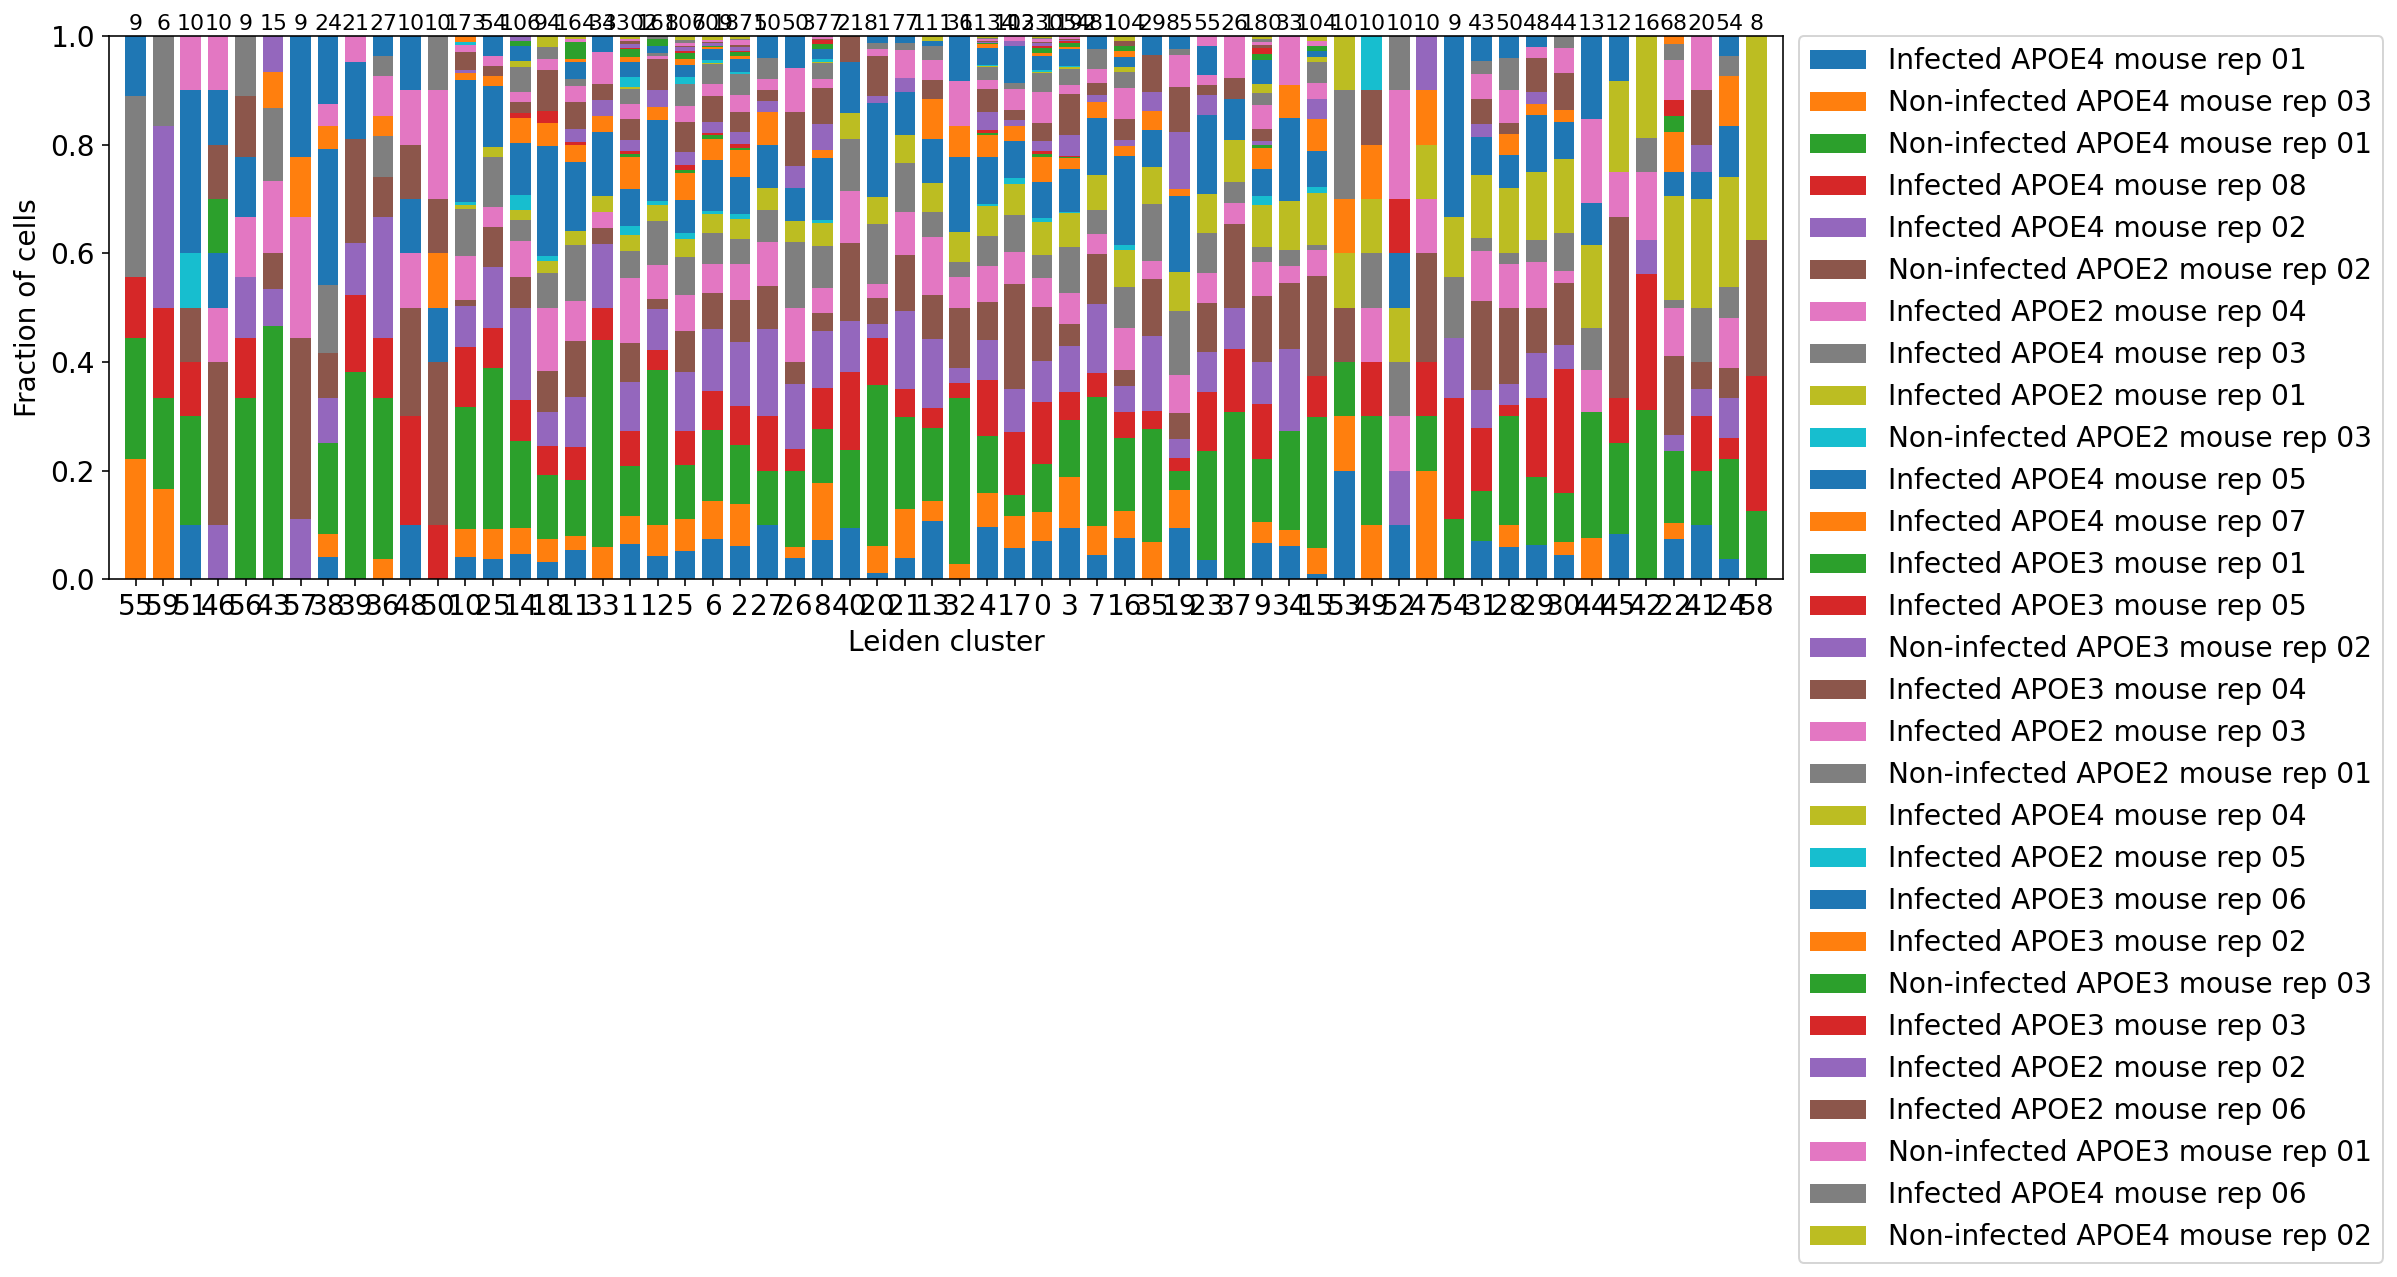

In [320]:
plot_fraction_per_sample(
    palmdb_adata_fil,
    groups="leiden",
    fractions="title",
    normalize_to_total=False,
    title=None,
    xticklabel_rotation=0
)

/tmp/ipykernel_116318/4143862490.py:90: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(clusters)


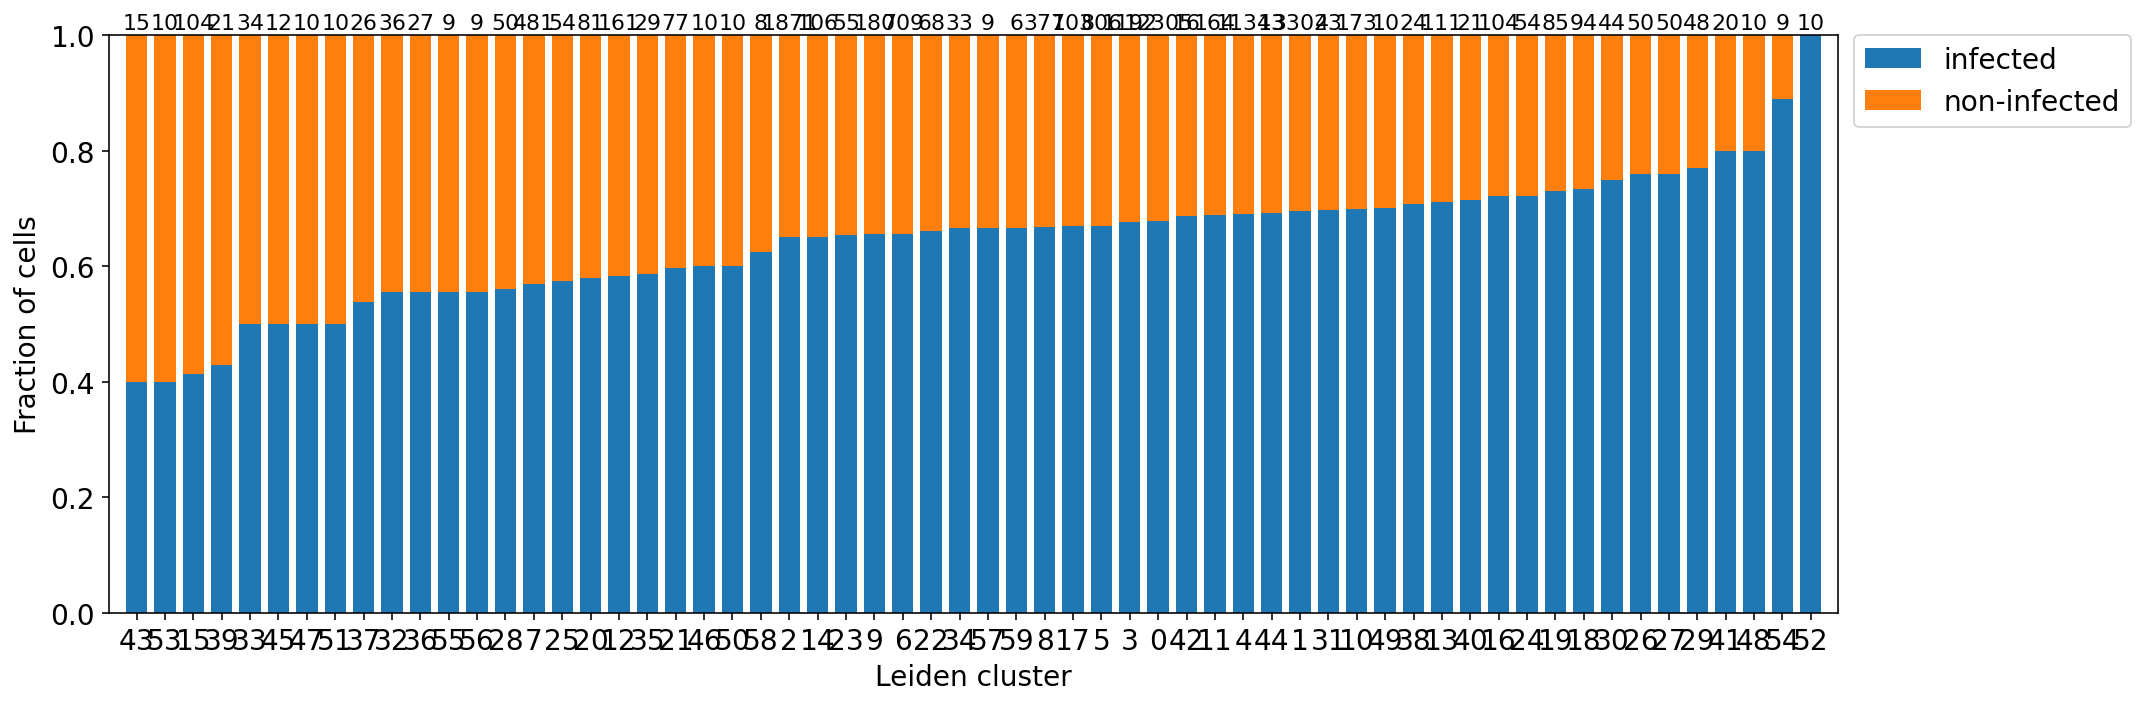

In [321]:
plot_fraction_per_sample(
    palmdb_adata_fil,
    groups="leiden",
    fractions="condition",
    normalize_to_total=False,
    title=None,
    xticklabel_rotation=0
)

___

In [322]:
palmdb_adata.write(f"{fastq_folder}/virus/virus_all.h5ad")

In [323]:
palmdb_adata_fil.write(f"{fastq_folder}/virus/virus_all_fil.h5ad")